In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import shapely
import rioxarray as rxr
import rasterio
from affine import Affine


In [2]:
cutBox = [114, 32, 121, 40]
cutFrame = shapely.geometry.box(*cutBox)

cutGdf = gpd.GeoDataFrame({'geometry': cutFrame}, index=[
                          0], crs={'init': 'epsg:4326'})
cutGdf.explore()


/home/zyzh0/anaconda3/envs/gis/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [3]:
precipFrame = xr.open_dataset(r"../datas/PRECIP/extracted/pre_2000_2002.nc",decode_coords=True)
precipFrame.rio.write_crs(4326, inplace=True)
precipFrame.rio.set_spatial_dims(
    x_dim="lon", y_dim="lat", inplace=True).rio.write_coordinate_system(inplace=True)


<xarray.Dataset>
Dimensions:      (lon: 7680, lat: 4717, time: 36)
Coordinates:
  * lon          (lon) float64 72.2 72.21 72.22 72.23 ... 136.2 136.2 136.2
  * lat          (lat) float64 55.55 55.55 55.54 55.53 ... 16.27 16.26 16.25
  * time         (time) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
    spatial_ref  int64 0
Data variables:
    pre          (time, lat, lon) float32 ...

In [4]:
precipFrame.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...

In [5]:
def cutFrame(datFrame,ctBox):
    return datFrame.rio.clip(ctBox.geometry,crs=precipFrame.rio.crs,drop=True)

In [6]:
cutPrecip = cutFrame(precipFrame,cutGdf)


In [7]:
cutPrecip.loc[dict(time=1)].rename(lon="x",lat="y").pre


<xarray.DataArray 'pre' (y: 960, x: 840)>
array([[ 93.,  93.,  93., ...,  nan,  nan,  nan],
       [ 94.,  94.,  94., ...,  nan,  nan,  nan],
       [ 94.,  94.,  94., ...,  nan,  nan,  nan],
       ...,
       [452., 452., 452., ..., 646., 646., 645.],
       [452., 452., 453., ..., 646., 645., 645.],
       [452., 452., 434., ..., 665., 645., 645.]], dtype=float32)
Coordinates:
  * x            (x) float64 114.0 114.0 114.0 114.0 ... 121.0 121.0 121.0 121.0
  * y            (y) float64 40.0 39.99 39.98 39.97 ... 32.03 32.02 32.01 32.0
    time         float64 1.0
    spatial_ref  int64 0
Attributes:
    unit:       0.1 mm
    long_name:  monthly precipitation

In [8]:
baseDir = r"../datas/PRECIP/extracted/"
fileNameLst =[]
for i in range(6):
    fileNameLst.append(baseDir+f"pre_{i*3+2000}_{i*3+2002}.nc")

oBaseDir = r"../outputs/precip-cutted/"


In [9]:
for i in fileNameLst:
    precipFrame = xr.open_dataset(i,decode_coords=True)
    precipFrame.rio.write_crs(4326, inplace=True)
    precipFrame.rio.set_spatial_dims(
        x_dim="lon", y_dim="lat", inplace=True).rio.write_coordinate_system(inplace=True)
    cutPrecip = cutFrame(precipFrame,cutGdf)
    cutPrecip.rename(lon="x", lat="y")
    for j in range(36):
        outPath = oBaseDir+f"{i[-13:-3]}_{j+1}.tif"
        cutPrecip.loc[dict(time=j+1)].rio.to_raster(outPath)


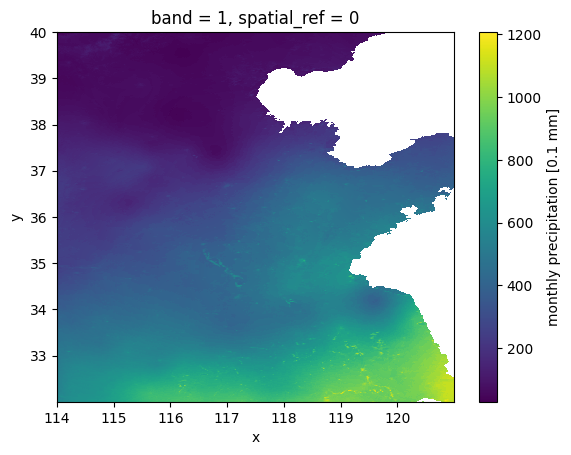

In [10]:
cutted = xr.open_dataset(r"../outputs/precip-cutted/_2000_2002_11.tif")
cutted.band_data.plot()